# A Recurrent Network Mechanism of Time Integration in Perceptual Decisions
Wong,  Wang
Journal of Neuroscience, January 2006, 26(4):1212-1328

## Material and Methods
### The two-variable network model

### Calling Library Fuctions

In [1]:
# LIBRARY

import numpy as np # vector manipulation
import math  # math functions
import sys

# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")


### The Reduced Network Model

In [2]:
def H(x):
    a=270
    b=108
    d=0.154
    f=(a*x-b)/(1-np.exp(-d*(a*x-b)))
    return f


### Neural Circuit
$$ x_{1}=J_{11}S_1-J_{12}S_2+I_{0}+I_{1}+I_{noise,1}$$
$$ x_{2}=J_{22}S_2-J_{21}S_1+I_{0}+I_{2}+I_{noise,1}$$

where the synaptic couplings are $J_{11}=0.2609$, $J_{22}=0.2609$, $J_{12}=0.0497$ and $J_{21}=0.0497$.
$I_{0}=0.3255 nA$ represents external input 


In [3]:
def total_synaptic_current(S_1,S_2,I_1,I_2,I_noise_1,I_noise_2):
    # Synaptic coupling
    J_11=0.2609 # nA
    J_22=0.2609 # nA
    J_12=0.0497 # nA
    J_21=0.0497 # nA
    I_0=0.3255  # nA
    x_1=J_11*S_1-J_12*S_2+I_0+I_1+I_noise_1
    x_2=J_22*S_2-J_21*S_1+I_0+I_2+I_noise_2
    return x_1, x_2

def total_synaptic_current_JB(S_L,S_R,I_L,I_R,I_noise_L,I_noise_R,direction):
    # Synaptic coupling
    J_LL=J_RR=0.2609 # nA
    J_LR=J_RL=0.0497 # nA
    I_0=0.3255  # nA
    x_L=J_LL*S_L-J_LR*S_R+I_0+I_L+I_noise_L
    x_R=J_RR*S_R-J_RL*S_L+I_0+I_R+I_noise_R
    if (direction == "L"):
        x=J_LL*S_L-J_LR*S_R+I_0+I_L+I_noise_L
    elif(direction == "R"):
        x=J_RR*S_R-J_RL*S_L+I_0+I_R+I_noise_R
    return x#_1, x_2




### Background activity
$$ \tau_{AMPA}\frac{d I_{noise,i}(t)}{dt} =-I_{noise,i}(t)+\eta_i(t)\sqrt{\tau_{AMPA}}\sigma_{noise}$$

In [4]:
def Background_Activity(I_noise,h):
    
    sigma_noise=0.02 # nA
    tau_AMPA=2/1000#ms
    eta_noise=np.random.normal(0,1,(1,M))
    I_0=0.0#3255  # nA
    I_noise_new=I_noise+(h)/tau_AMPA*(-(I_noise-I_0)+eta_noise*np.sqrt(tau_AMPA)*sigma_noise)
    return I_noise_new

### Network Dynamics
$$ \frac{d S_{i}}{dt} =-\frac{S_{i}}{\tau_S}+(1-S_{i})\gamma H_{i}$$

In [5]:
#def Network_Dynamics(S,x):
#    h=0.1/1000 #ms
#    gamma=0.641
#    tau_S=.100 #s
#    k=(-S/tau_S+(1-S)*gamma*H(x)/1)
#    S_new=S+h*k#(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
#    return S_new

def Network_Dynamics(S,x,h):
    tau_S=100/1000#100 #ms
    𝛾=0.641
    S_new=S+h*((-S/tau_S)+(1-S)*𝛾*H(x))
    return S_new

### Input Current Target

$$ I_i=J_{A,ext}\mu_0\left(1+ \frac{c'}{100} \right) $$


In [6]:
def I_input_1(c_dash):
    J_A_ext=5.2/10000# nA/Hz
    mu_0=30 # Hz
    f=1.0
    p=0
    I_motion=J_A_ext*mu_0*(1+f*(c_dash+p)/100)
    return I_motion

$$ I_2=J_{A,ext}\mu_0\left(1- \frac{c'}{100} \right) $$

In [7]:
def I_input_2(c_dash):
    J_A_ext=5.2/10000# nA/Hz
    mu_0=30 # Hz
    f=1.0
    p=0
    I_motion=J_A_ext*mu_0*(1+f*(-c_dash+p)/100)
    return I_motion

In [8]:
h=0.1/1000
time=np.arange(-0.2,1.5,h)
J_A_ext=5.2/10000 # nA/Hz
mu_0=30 # Hz
Vector_coherence=[2,3,4,5,6,7,8,9,10,20,50]


Threshold=15
M=1000
RT_coh_hit=np.zeros(len(Vector_coherence))
RT_coh_miss=np.zeros(len(Vector_coherence))
Prob=np.zeros(len(Vector_coherence))
count=0
#fig = plt.figure(figsize=(12,8))

ALL_F_1=0.2*np.ones((M,len(time)))
ALL_F_2=0.2*np.ones((M,len(time)))
I_1=0.0*np.ones((M,len(time))) # np.zeros((1,len(time)))
I_2=0.0*np.ones((M,len(time))) # np.zeros((1,len(time)))
Firing_target_1=5*np.ones((M,len(time))) # np.zeros((1,len(time)))
Firing_target_2=5*np.ones((M,len(time))) # np.zeros((1,len(time)))

In [9]:
for j in range(0,len(Vector_coherence)):
    Threshold=15
    print("Coherence:", Vector_coherence[j])
    ANSWER=np.zeros(M)
    RT=np.zeros(M)
    count=np.zeros(M)

    x_1=J_A_ext*mu_0*np.ones((M,len(time)))
    x_2=J_A_ext*mu_0*np.ones((M,len(time)))

    S=0.2
    S_1=S+np.random.normal(0,0.01,(M,len(time)))#0.1*np.random.uniform(0,1,len(time))# np.random.normal(0,1,len(time))*0.0004
    S_2=S+np.random.normal(0,0.01,(M,len(time))) #0.1*np.random.uniform(0,1,len(time)) #np.random.normal(0,1,len(time))*0.0004

    I_noise_1=0.004*np.random.uniform(0,1,(M,len(time)))   # initalise noisy input as normal distribution
    I_noise_2=0.004*np.random.uniform(0,1,(M,len(time)))   # why multiply by 0.004? Or how to know to do this  ?

    Firing_target_1[:,0]=H(x_1[:,0])
    Firing_target_2[:,0]=H(x_2[:,0])


 #   count=0
    for i in range (0,len(time)-1):
        
        if time[i] >=0 and time[i]<1:
            c_dash=Vector_coherence[j]
        else:
            c_dash=0.0


        I_noise_1[:,i+1]=Background_Activity(I_noise_1[:,i],h)
        I_noise_2[:,i+1]=Background_Activity(I_noise_2[:,i],h)

        I_1[:,i+1]=I_input_1(c_dash)
        I_2[:,i+1]=I_input_2(c_dash)

        S_1[:,i+1]=Network_Dynamics(S_1[:,i],x_1[:,i],h)
        S_2[:,i+1]=Network_Dynamics(S_2[:,i],x_2[:,i],h)
        x_1[:,i+1],x_2[:,i+1]=total_synaptic_current(S_1[:,i+1],S_2[:,i+1],I_1[:,i+1],
                                                     I_2[:,i+1],I_noise_1[:,i+1],I_noise_2[:,i+1])

        Firing_target_1[:,i+1]=H(S_1[:,i+1])
        Firing_target_2[:,i+1]=H(S_2[:,i+1])
        if time[i]>=0.75:
            Threshold=15-(time[i]-0.75)*100
        else:
            Threshold=15
            
        if time[i] >=0:
            RT[(np.abs(Firing_target_1[:,i+1]-Firing_target_2[:,i+1])>Threshold) & (count==0)]=time[i]
       
            ANSWER[(Firing_target_1[:,i+1]>15)]=1
            count[(np.abs(Firing_target_1[:,i+1]-Firing_target_2[:,i+1])>Threshold) ]=1
   
     
    RT_coh_hit[j]=np.average(RT[ANSWER==1])
    RT_coh_miss[j]=np.average(RT[ANSWER==0])
    Prob[j]=np.average(ANSWER)
    

Coherence: 2
Coherence: 3
Coherence: 4
Coherence: 5
Coherence: 6
Coherence: 7
Coherence: 8
Coherence: 9
Coherence: 10
Coherence: 20
Coherence: 50


### Plotting
#### Input

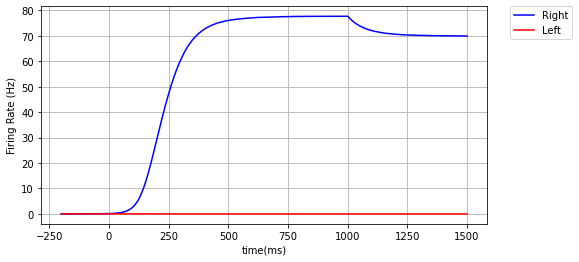

In [10]:
fig = plt.figure(figsize=(8,4))

plt.plot(time*1000,Firing_target_1[1,:],'-',color='blue',label="Right")
plt.plot(time*1000,Firing_target_2[1,:],'-',color='red',label="Left")
plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('Firing Rate (Hz)')
#plt.ylim((0,Threshold*1.5))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('Vector_Example_Firing_Pattern.png', bbox_inches='tight',dpi=300)

plt.show()


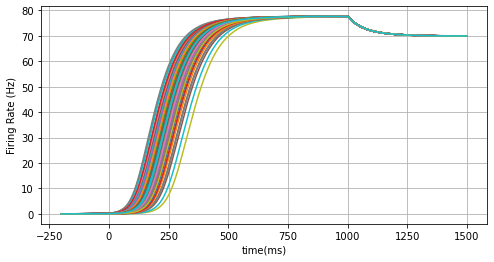

In [11]:
fig = plt.figure(figsize=(8,4))

for j in range(0,100):
    plt.plot(time*1000,Firing_target_1[j,:])

plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('Firing Rate (Hz)')
#plt.ylim((0,Threshold*1.5))

plt.savefig('Vector_Example_Firing_Pattern.png', bbox_inches='tight',dpi=300)

plt.show()



## Behavioural Results
The Behavioural data were fit with the function
$$ p(c)=1-e^{(-(\frac{c}{alpha})^{\beta})} $$
where $p(c)$ is the probability of a correct response, $c$ is coherence level, $\alpha$ is the discrimination threshold at which the performance is 82% correct, and $\beta$ describes the slope of the psychometric function.
The function is fit using the __curve_fit__ function form the __scipy__ library with the initial guess of $\alpha=7$ and $\beta=1.25$ taken from (Roitman and Shadlen, 2002).

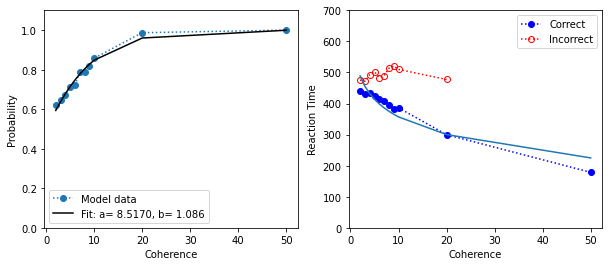

In [12]:
from scipy.optimize import curve_fit
from scipy import stats

def func_temp(coh,alpha,beta):
    return 1-0.5*np.exp(-(coh/alpha)**beta)

popr,_=curve_fit(func_temp,Vector_coherence,Prob,p0=[7,1.25]) # Initial values Shadlen et al

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(Vector_coherence),RT_coh_hit*1000)

fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(Vector_coherence,Prob,'o:',label='Model data')
Vector_coh=np.arange(np.min(Vector_coherence),np.max(Vector_coherence),0.1)

plt.plot(Vector_coherence,func_temp(Vector_coherence,*popr),'k',label='Fit: a= %0.4f, b= %0.3f'% tuple(popr))
plt.legend()



plt.xlabel('Coherence')
plt.ylabel('Probability')
#plt.xscale('log')
plt.ylim(0,1.1)
plt.subplot(122)
plt.plot((Vector_coherence),RT_coh_hit*1000,'o:',color='blue',label="Correct")
plt.plot((Vector_coherence),RT_coh_miss*1000,'o:',fillstyle='none',color='red',label="Incorrect")
plt.plot((Vector_coherence),slope*np.log(Vector_coherence)+intercept)
#plt.xscale('log')
plt.legend()
plt.ylim(0,700)
plt.xlabel('Coherence')
plt.ylabel('Reaction Time')
#plt.savefig('Vec_Behavioural.png', bbox_inches='tight',dpi=300)
plt.show()

## References
Roitman JD, Shadlen MN (2002) Response of neurons in the lateral intraparietal area during a combined visual discrimination reaction time task. J Neurosci 22:9475–9489.

Wong, K. F., & Wang, X. J. (2006). A recurrent network mechanism of time integration in perceptual decisions. Journal of Neuroscience, 26(4), 1314-1328.


In [13]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(Vector_coherence),RT_coh_hit*1000)

In [14]:
slope

-81.99722023418747

In [15]:
intercept

545.7467006497861

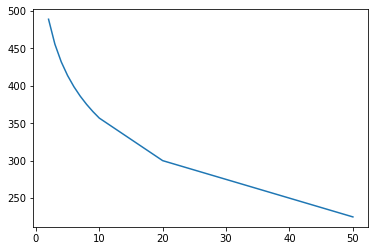

In [16]:
plt.plot((Vector_coherence),slope*np.log(Vector_coherence)+intercept)